In [45]:
import polars as pl 
import seaborn as sns

In [34]:
frame = pl.read_parquet(r"C:\Users\faune\Downloads\0000.parquet")

In [50]:
frame.drop('idx').with_columns(pl.col('label').replace({0:'negative', 1: 'positive'}))

sentence,label
str,str
"""hide new secre…","""negative"""
"""contains no wi…","""negative"""
"""that loves its…","""positive"""
"""remains utterl…","""negative"""
"""on the worst r…","""negative"""
…,…
"""a delightful c…","""positive"""
"""anguish , ange…","""negative"""
"""at achieving t…","""positive"""


<Axes: xlabel='label', ylabel='Count'>

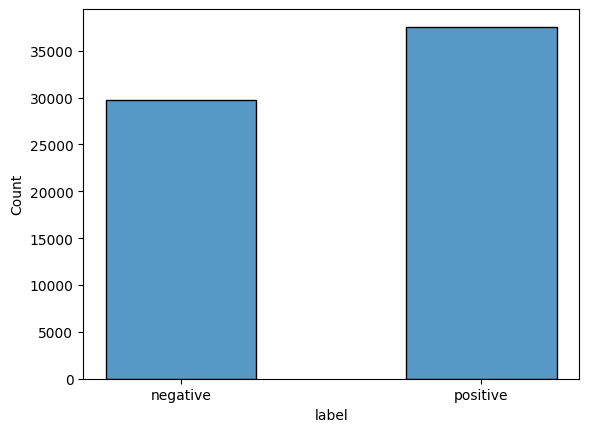

In [55]:
sns.histplot(data = frame.drop('idx').with_columns(pl.col('label').replace({0:'negative', 1: 'positive'})), x='label', shrink=.5) #.pivot(values='sentence', index='idx', columns='label').drop('idx').describe()

In [59]:
frame.pivot(values='sentence', index='idx', columns='label').drop('idx').describe()

statistic,0,1
str,str,str
"""count""","""29780""","""37569"""
"""null_count""","""37569""","""29780"""
"""mean""",null,null
"""std""",null,null
"""min""","""$ 99 bargain-b…","""$ 1.8 million …"
"""25%""",null,null
"""50%""",null,null
"""75%""",null,null
"""max""","""zzzzzzzzz ""","""zoom ! """


In [98]:
(
    frame
    .drop('idx')
    .with_columns(pl.col('label').replace({0:'negative', 1: 'positive'}))
    .sort('label', descending=True)
    .unstack(step=37569, how="vertical", columns='sentence')
    .rename({'sentence_0': 'positive', 'sentence_1':'negative'})
    .with_columns(pl.col('*').str.split(' '))
    .with_columns(pl.col('positive').list.set_intersection('negative').alias('similar_words'))
    .with_columns(pl.col('similar_words').list.len().alias('nb_similar_words'))
    .with_columns(pl.col('positive').list.len().alias('nb_positive_words'))
    .with_columns(pl.col('negative').list.len().alias('nb_negative_words'))
    .sort(['nb_positive_words', 'nb_negative_words'])
    .with_columns(pl.col('nb_similar_words').truediv(pl.col('nb_positive_words')).alias('ratio_positive'))
    .with_columns(pl.col('nb_similar_words').truediv(pl.col('nb_negative_words')).alias('ratio_negative'))
    .with_columns(pl.mean_horizontal(pl.col('ratio_positive'), pl.col('ratio_negative')).alias('ratio_mean'))
    .with_columns(pl.col('ratio_positive').sub(pl.col('ratio_negative')).abs().alias('ratio_diff'))
    .sort(pl.col('similar_words').list.len(), descending=True)
    # .with_columns(pl.col('nb_similar_words').replace({0: None, 1: None}))
    # .drop_nulls(subset='nb_similar_words')
    .sort('ratio_mean', descending=True)
    .sort('ratio_diff')
    .with_columns(pl.col('positive').list.join(' '))
    .with_columns(pl.col('negative').list.join(' '))
    .filter(pl.col('ratio_mean').ge(0.5), pl.col('ratio_diff').le(0.5))
)

positive,negative,similar_words,nb_similar_words,nb_positive_words,nb_negative_words,ratio_positive,ratio_negative,ratio_mean,ratio_diff
str,str,list[str],u32,u32,u32,f64,f64,f64,f64
"""so real ""","""so low ""","[""so"", """"]",2,3,3,0.666667,0.666667,0.666667,0.0
"""a warmth ""","""a waste ""","[""a"", """"]",2,3,3,0.666667,0.666667,0.666667,0.0
"""of the film 's…","""the film 's th…","[""the"", ""film"", … """"]",4,7,7,0.571429,0.571429,0.571429,0.0
"""the tooth and …","""through the pi…","[""the"", ""and"", … """"]",4,8,8,0.5,0.5,0.5,0.0
"""suspense , int…","""coarse , clich…","["","", ""and"", """"]",3,6,6,0.5,0.5,0.5,0.0
…,…,…,…,…,…,…,…,…,…
"""and sublime mu…","""go unnoticed a…","[""and"", ""music"", """"]",3,4,8,0.75,0.375,0.5625,0.375
"""is so fine ""","""her real-life …","[""is"", ""so"", """"]",3,4,9,0.75,0.333333,0.541667,0.416667
"""such a buoyant…","""such a tragedy…","[""such"", ""a"", """"]",3,9,4,0.333333,0.75,0.541667,0.416667


In [10]:
pl.DataFrame(req.json()['features']).unnest('type')

feature_idx,name,dtype,_type,names
i64,str,str,str,list[str]
0,"""idx""","""int32""","""Value""",null
1,"""sentence""","""string""","""Value""",null
2,"""label""",null,"""ClassLabel""","[""negative"", ""positive""]"
